In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Activation

from sklearn.model_selection import train_test_split

import seaborn as sns

In [3]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation, ELU, Add
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.preprocessing.image import ImageDataGenerator


In [15]:
from sklearn import preprocessing


In [7]:
dataDir = "/Users/donchan/Documents/myData/KaggleData/Iceberg"

In [8]:
import os
train_data = os.path.join(dataDir,"data/processed/train.json")
test_data = os.path.join(dataDir,"data/processed/test.json")


# loading data #

In [9]:
print("load data...")


train = pd.read_json(train_data)
test = pd.read_json(test_data)
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
print("done!")

load data...
done!


In [27]:
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])

x1_shape = x_band1.shape
x2_shape = x_band2.shape

scaler = preprocessing.StandardScaler()
mm_scaler = preprocessing.MinMaxScaler()
stand_x_band1 = mm_scaler.fit_transform(x_band1.reshape(-1,1))
stand_x_band2 = mm_scaler.fit_transform(x_band2.reshape(-1,1))
x_band1_st = stand_x_band1.reshape(x1_shape)
x_band2_st = stand_x_band2.reshape(x2_shape)


In [28]:
x_band1.shape,x_band2.shape,x_band1_st.shape,x_band2_st.shape

((1604, 75, 75), (1604, 75, 75), (1604, 75, 75), (1604, 75, 75))

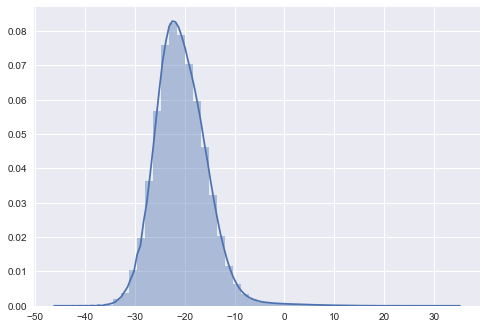

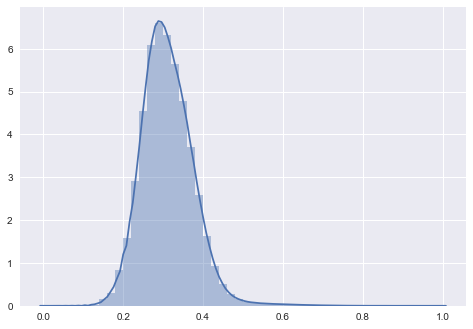

In [26]:
sns.distplot(stand_x_band1)

In [29]:
X_train = np.concatenate([x_band1_st[:, :, :, np.newaxis]
                          , x_band2_st[:, :, :, np.newaxis]
                         , ((x_band1_st+x_band1_st)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_train = np.array(train.inc_angle)
y_train = np.array(train["is_iceberg"])





In [31]:
np.corrcoef(X_angle_train,y_train)

array([[ 1.        ,  0.26628294],
       [ 0.26628294,  1.        ]])

# One hot code y_train #

In [32]:
oh = preprocessing.OneHotEncoder(sparse=False)
y_train_oh = oh.fit_transform( y_train[:,np.newaxis])


# Split Training and Validation #

In [33]:
x_train, x_valid, y_train_oh, y_valid_oh = train_test_split(X_train, y_train_oh, test_size=0.2, random_state=42)

In [34]:
x_train.shape, x_valid.shape, y_train_oh.shape, y_valid_oh.shape

((1283, 75, 75, 3), (321, 75, 75, 3), (1283, 2), (321, 2))

In [35]:
train["is_iceberg"].value_counts()

0    851
1    753
Name: is_iceberg, dtype: int64

# Keras Model Definiton #

In [36]:
def get_model():
    bn_model = 0.99
    p_activation = "elu"
    k_size = (5,5)
    input_1 = Input(shape=(75, 75, 3), name="X_1")
    input_2 = Input(shape=[1], name="angle")
    
    img_1 = Conv2D(32, kernel_size = k_size, activation=p_activation, padding="same") ((BatchNormalization(momentum=bn_model))(input_1))
    img_1 = Conv2D(32, kernel_size = k_size, activation=p_activation, padding="same") (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.25)(img_1)

    img_1 = Conv2D(64, kernel_size = k_size, activation=p_activation, padding="same")((BatchNormalization(momentum=bn_model))(img_1))
    img_1 = Conv2D(64, kernel_size = k_size, activation=p_activation, padding="same")(img_1)
    img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
    img_1 = Dropout(0.25)(img_1)    
    
    print("img1 shape", img_1.shape)

    img_resid = Conv2D(128, kernel_size = k_size, activation=p_activation, padding="same")((BatchNormalization(momentum=bn_model))(img_1))
    img_resid = Conv2D(128, kernel_size = k_size, activation=p_activation, padding="same")(img_resid)
    img_resid = Dropout(0.25)(img_resid)    
    print("img_resid shape1", img_resid.shape)
    
    img_resid = Conv2D(64, kernel_size = k_size, activation=p_activation, padding="same")((BatchNormalization(momentum=bn_model))(img_resid))
    img_resid = Conv2D(64, kernel_size = k_size, activation=p_activation, padding="same")(img_resid)
    print("img_resid shape2", img_resid.shape)

    cnn_resid_added = Add()([img_1, img_resid])
    print("cnn_resid shape", cnn_resid_added.shape)
    
    top_cnn = Conv2D(128, kernel_size = k_size, activation=p_activation, padding="same")((BatchNormalization(momentum=bn_model))(cnn_resid_added))
    top_cnn = Conv2D(128, kernel_size = k_size, activation=p_activation, padding="same")(top_cnn)
    top_cnn = MaxPooling2D((2,2)) (top_cnn)
    top_cnn = Conv2D(256, kernel_size = k_size, activation=p_activation, padding="same")((BatchNormalization(momentum=bn_model))(top_cnn))
    top_cnn = Conv2D(256, kernel_size = k_size, activation=p_activation, padding="same")(top_cnn)
    top_cnn = Dropout(0.25)(top_cnn)
    top_cnn = MaxPooling2D((2,2)) (top_cnn)
    top_cnn = Conv2D(512, kernel_size = k_size, activation=p_activation, padding="same")((BatchNormalization(momentum=bn_model))(top_cnn))
    top_cnn = Conv2D(512, kernel_size = k_size, activation=p_activation, padding="same")(top_cnn)
    top_cnn = Dropout(0.25)(top_cnn)
    top_cnn = MaxPooling2D((2,2)) (top_cnn)
    
    top_cnn = GlobalMaxPooling2D()(top_cnn)
    print("top_cnn shape", top_cnn.shape)

    dense_ayer = ELU()(BatchNormalization(momentum=bn_model)( Dense(512, activation=None)(top_cnn) ))
    dense_ayer = Dropout(0.5)(dense_ayer)
    dense_ayer = ELU()(BatchNormalization(momentum=bn_model)( Dense(256, activation=None)(dense_ayer) ))
    dense_ayer = Dropout(0.5)(dense_ayer)
    
    # 2 for One Hot code for Binary 
    output = Dense(2, activation="softmax")(dense_ayer)
    
    
    
    model = Model([input_1],  output)
    #optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    optimizer = Adam(lr=0.001)
    
    #model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["categorical_accuracy"])

    
    return model


In [37]:
model = get_model()
model.summary()

('img1 shape', TensorShape([Dimension(None), Dimension(18), Dimension(18), Dimension(64)]))
('img_resid shape1', TensorShape([Dimension(None), Dimension(18), Dimension(18), Dimension(128)]))
('img_resid shape2', TensorShape([Dimension(None), Dimension(18), Dimension(18), Dimension(64)]))
('cnn_resid shape', TensorShape([Dimension(None), Dimension(18), Dimension(18), Dimension(64)]))
('top_cnn shape', TensorShape([Dimension(None), Dimension(512)]))
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
X_1 (InputLayer)                 (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 75, 75, 3)     12          X_1[0][0]                        
___________________________________________

# training parameters #

In [39]:
batch_size = 32
epochs = 25 ## change this to 80
#steps_per_epoch=np.power(2,14) /batch_size ## change to 2^14

#print(steps_per_epoch)

# Callback definition #

In [40]:
def get_callbacks(filepath, patience=10):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

file_path = "keras_model2_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [44]:
gen_images = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        #rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,)
        #fill_mode='nearest')

model.fit_generator(
    
        gen_images.flow(x_train,y_train_oh,batch_size=batch_size),
        steps_per_epoch=np.ceil(8.0 * float(y_train_oh.shape[0]) / float(batch_size)),
        epochs=epochs,
        validation_data=(x_valid,y_valid_oh),
        validation_steps=np.ceil(8.0 * float(y_valid_oh.shape[0]) / float(batch_size)), 
        callbacks=callbacks)

Epoch 1/25
321/321 [==============================] - 2259s - loss: 0.7961 - categorical_accuracy: 0.5724 - val_loss: 0.7035 - val_categorical_accuracy: 0.5109
Epoch 2/25
 60/321 [====>.........................] - ETA: 90456s - loss: 0.7181 - categorical_accuracy: 0.5847

KeyboardInterrupt: 

In [39]:
model.load_weights(filepath=file_path)
score = model.evaluate(x_valid, y_valid_oh, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


512/530 [===========================>..] - ETA: 0sTest loss: 0.265724973296
Test accuracy: 0.884905660602


In [40]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)







#x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
#x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
#X_train = np.concatenate([x_band1[:, :, :, np.newaxis]
#                          , x_band2[:, :, :, np.newaxis]
#                         , ((x_band1+x_band1)/2)[:, :, :, np.newaxis]], axis=-1)


In [50]:
prediction = model.predict([X_test], verbose=1, batch_size=200)

8400/8424 [============================>.] - ETA: 0s

In [53]:
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction[:,1]})

In [54]:
submission.head()

,id,is_iceberg
0,5941774d,0.695578
1,4023181e,0.113909
2,b20200e4,0.000026
3,e7f018bb,0.966803
4,4371c8c3,0.020416


In [55]:
submission.to_csv("output/keras_model2_basic.csv",index=False)

In [ ]:


input_CNN = input_img_norm %>%
    layer_conv_2d(32, kernel_size = kernel_size,padding = "same") %>%
    layer_batch_normalization(momentum = 0.99) %>%
    layer_activation_elu() %>%
    layer_max_pooling_2d(c(2,2)) %>%
    layer_dropout(0.25) %>%
    layer_conv_2d(64, kernel_size = kernel_size,padding = "same") %>%
    layer_batch_normalization(momentum = 0.99) %>%
    layer_activation_elu() %>%
    layer_max_pooling_2d(c(2,2)) %>%
    layer_dropout(0.25) 

## first residual
input_CNN_residual = input_CNN %>%
  layer_batch_normalization(momentum = 0.99) %>%
  layer_conv_2d(128, kernel_size = kernel_size,padding = "same") %>%
  layer_batch_normalization(momentum = 0.99) %>%
  layer_activation_elu() %>%
  layer_dropout(0.25) %>%
  layer_conv_2d(64, kernel_size = kernel_size,padding = "same") %>%
  layer_batch_normalization(momentum = 0.99) %>%
  layer_activation_elu()

input_CNN_residual = layer_add(list(input_CNN_residual,input_CNN))

top_CNN = input_CNN_residual %>%
  layer_conv_2d(128, kernel_size = kernel_size,padding = "same") %>%
  layer_batch_normalization(momentum = 0.99) %>%
  layer_activation_elu() %>%
  layer_max_pooling_2d(c(2,2)) %>%
  layer_conv_2d(256, kernel_size = kernel_size,padding = "same") %>%
  layer_batch_normalization(momentum = 0.99) %>%
  layer_activation_elu() %>%
  layer_dropout(0.25) %>%
  layer_max_pooling_2d(c(2,2)) %>%
  layer_conv_2d(512, kernel_size = kernel_size,padding = "same") %>%
  layer_batch_normalization(momentum = 0.99) %>%
  layer_activation_elu() %>%
  layer_dropout(0.25) %>%
  layer_max_pooling_2d(c(2,2)) %>%
  layer_global_max_pooling_2d()

outputs = top_CNN %>%
    layer_dense(512,activation = NULL) %>%
    layer_batch_normalization(momentum = 0.99) %>%
    layer_activation_elu() %>%
    layer_dropout(0.5) %>%
    layer_dense(256,activation = NULL) %>%
    layer_batch_normalization(momentum = 0.99) %>%
    layer_activation_elu() %>%
    layer_dropout(0.5) %>%
    layer_dense(2,activation = "softmax") ## not sure using softmax is the right thing to do...
    
model <- keras_model(inputs = list(input_img), outputs = list(outputs))

model %>% compile(optimizer=optimizer_adam(lr = 0.001),
                  loss="binary_crossentropy",
                  metrics = c("accuracy"))

summary(model)